Imports and Setup

In [ ]:
%pip install cmdstanpy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cmdstanpy
from cmdstanpy import install_cmdstan
install_cmdstan()
from cmdstanpy import CmdStanModel


np.random.seed(42)

DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


CmdStan install directory: /root/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


Stan file generation(so we dont need many files)

In [ ]:
stan_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0.000001> sigma2;
}
model {
  sigma2 ~ inv_gamma(1, 1);
  alpha ~ normal(0, 10);
  beta ~ normal(0, 10);
  y ~ normal(alpha + beta * x, sqrt(sigma2));
}
generated quantities {
  real sigma = sqrt(sigma2);
}
"""

# Need to write this to the file for cmdstan. This is the only appreciable difference I noticed between cmdstan and pystan (no need to do this for pystan)
with open('linear_regression.stan', 'w') as f:
    f.write(stan_code)

Simulate and run stan model

In [ ]:
true_alpha = 2.3
true_beta = 4.0
true_sigma = 2.0

# First sample with 100
N_1 = 100
x_1 = np.random.normal(size=N_1)
y_1 = true_alpha + true_beta * x_1 + true_sigma * np.random.normal(size=N_1)


data_1 = {'N': N_1, 'x': x_1, 'y': y_1}


model = CmdStanModel(stan_file='linear_regression.stan')
fit_1 = model.sample(
    data=data_1,
    iter_warmup=1000,
    iter_sampling=1000,
    chains=4,
    seed=42
)

DEBUG:cmdstanpy:Removing /content/linear_regression
00:46:29 - cmdstanpy - INFO - compiling stan file /content/linear_regression.stan to exe file /content/linear_regression
INFO:cmdstanpy:compiling stan file /content/linear_regression.stan to exe file /content/linear_regression
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=linear_regression.stan /content/linear_regression
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=linear_regression.stan --o=/content/linear_regression.hpp /content/linear_regression.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundial

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/linear_regression', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmpiiybyzv0/cge25bn2.json', 'output', 'file=/tmp/tmpiiybyzv0/linear_regressionm2chzrhy/linear_regression-20250320004650_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/linear_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmpiiybyzv0/cge25bn2.json', 'output', 'file=/tmp/tmpiiybyzv0/linear_regressionm2chzrhy/linear_regression-20250320004650_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/linear_regression', 'id=3', 'random', 'seed=42', 'data', 'file=/tmp/tmpiiybyzv0/cge25

00:46:50 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/linear_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmpiiybyzv0/cge25bn2.json', 'output', 'file=/tmp/tmpiiybyzv0/linear_regressionm2chzrhy/linear_regression-20250320004650_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpiiybyzv0/linear_regressionm2chzrhy/linear_regression-20250320004650_1.csv
 console_msgs (if any):
	/tmp/tmpiiybyzv0/linear_regressionm2chzrhy/linear_regression-20250320004650_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defa

Summarize Results and graph

Results for N = 100:
  Parameter  True Value  Posterior Mean  Posterior Std
0     alpha         2.3        2.306994       0.200797
1      beta         4.0        3.668706       0.213987
2     sigma         2.0        1.996592       0.141212


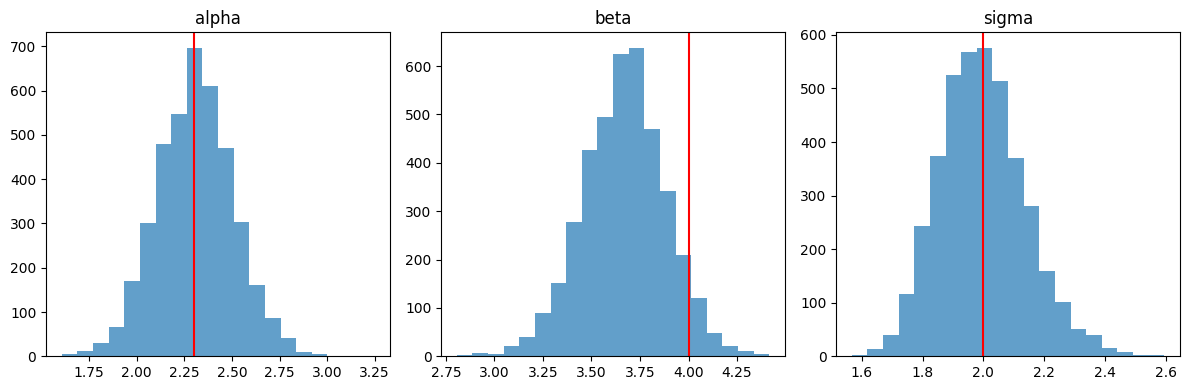

In [ ]:
posterior_1 = fit_1.stan_variables()

# Calculate posterior stats
alpha_mean_1 = np.mean(posterior_1['alpha'])
beta_mean_1 = np.mean(posterior_1['beta'])
sigma_mean_1 = np.mean(posterior_1['sigma'])

alpha_std_1 = np.std(posterior_1['alpha'])
beta_std_1 = np.std(posterior_1['beta'])
sigma_std_1 = np.std(posterior_1['sigma'])

# Summarize in table
summary_1 = pd.DataFrame({
    'Parameter': ['alpha', 'beta', 'sigma'],
    'True Value': [true_alpha, true_beta, true_sigma],
    'Posterior Mean': [alpha_mean_1, beta_mean_1, sigma_mean_1],
    'Posterior Std': [alpha_std_1, beta_std_1, sigma_std_1]
})
print("Results for N = 100:")
print(summary_1)

# Plot parameter posts
plt.figure(figsize=(12, 4))
params = ['alpha', 'beta', 'sigma']
true_values = [true_alpha, true_beta, true_sigma]

for i, (param, true_val) in enumerate(zip(params, true_values)):
    plt.subplot(1, 3, i+1)
    plt.hist(posterior_1[param], bins=20, alpha=0.7)
    plt.axvline(x=true_val, color='red')
    plt.title(param)

plt.tight_layout()

Repeat with 10x as many observations and summarize

DEBUG:cmdstanpy:cmd: /content/linear_regression info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiiybyzv0/cler4que.json
00:47:04 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/linear_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmpiiybyzv0/cler4que.json', 'output', 'file=/tmp/tmpiiybyzv0/linear_regression8qvsgskg/linear_regression-20250320004704_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/linear_regression', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmpiiybyzv0/cler4que.json', 'output', 'file=/tmp/tmpiiybyzv0/linear_regression8qvsgskg/linear_regression-20250320004704_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/linear_regression', 'id=3', 'random', 'seed=42', 'data', 'file=/tmp/tmpiiybyzv0/cler4

00:47:06 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/linear_regression', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmpiiybyzv0/cler4que.json', 'output', 'file=/tmp/tmpiiybyzv0/linear_regression8qvsgskg/linear_regression-20250320004704_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpiiybyzv0/linear_regression8qvsgskg/linear_regression-20250320004704_1.csv
 console_msgs (if any):
	/tmp/tmpiiybyzv0/linear_regression8qvsgskg/linear_regression-20250320004704_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defa



Results for N = 1000:
  Parameter  True Value  Posterior Mean  Posterior Std
0     alpha         2.3        2.255762       0.066806
1      beta         4.0        4.052339       0.066102
2     sigma         2.0        2.114559       0.048810

Uncertainty Reduction:
  Parameter  Std (N=100)  Std (N=1000)  Reduction Factor
0     alpha     0.200797      0.066806          3.005686
1      beta     0.213987      0.066102          3.237213
2     sigma     0.141212      0.048810          2.893108


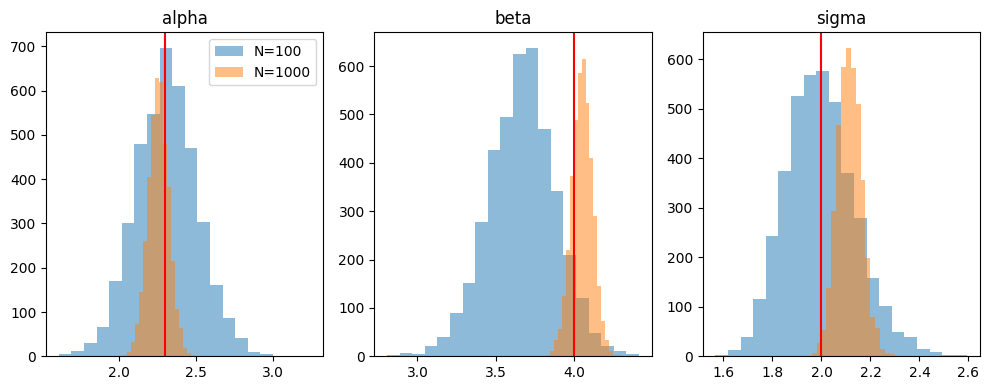

In [ ]:
N_2 = 1000
x_2 = np.random.normal(size=N_2)
y_2 = true_alpha + true_beta * x_2 + true_sigma * np.random.normal(size=N_2)
data_2 = {'N': N_2, 'x': x_2, 'y': y_2}


fit_2 = model.sample(
    data=data_2,
    iter_warmup=1000,
    iter_sampling=1000,
    chains=4,
    seed=42
)

# Extract post samples and calculate the stats
posterior_2 = fit_2.stan_variables()

alpha_mean_2 = np.mean(posterior_2['alpha'])
beta_mean_2 = np.mean(posterior_2['beta'])
sigma_mean_2 = np.mean(posterior_2['sigma'])

alpha_std_2 = np.std(posterior_2['alpha'])
beta_std_2 = np.std(posterior_2['beta'])
sigma_std_2 = np.std(posterior_2['sigma'])

# Table for this
summary_2 = pd.DataFrame({
    'Parameter': ['alpha', 'beta', 'sigma'],
    'True Value': [true_alpha, true_beta, true_sigma],
    'Posterior Mean': [alpha_mean_2, beta_mean_2, sigma_mean_2],
    'Posterior Std': [alpha_std_2, beta_std_2, sigma_std_2]
})
print("\nResults for N = 1000:")
print(summary_2)

# Compare uncertainty
std_reduction = pd.DataFrame({
    'Parameter': ['alpha', 'beta', 'sigma'],
    'Std (N=100)': [alpha_std_1, beta_std_1, sigma_std_1],
    'Std (N=1000)': [alpha_std_2, beta_std_2, sigma_std_2],
    'Reduction Factor': [alpha_std_1/alpha_std_2, beta_std_1/beta_std_2, sigma_std_1/sigma_std_2]
})
print("\nUncertainty Reduction:")
print(std_reduction)

# Compare posts using graphics
plt.figure(figsize=(10, 4))
for i, (param, true_val) in enumerate(zip(params, true_values)):
    plt.subplot(1, 3, i+1)
    plt.hist(posterior_1[param], bins=20, alpha=0.5, label='N=100')
    plt.hist(posterior_2[param], bins=20, alpha=0.5, label='N=1000')
    plt.axvline(x=true_val, color='red')
    plt.title(param)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()